# Homework 4: Sequence Models

## Task 0: Dataset and Analysis
In your project, you will pick a dataset (time-series) and an associated problem that can be
solved via sequence models. You must describe why you need sequence models to solve this
problem. Include a link to the dataset source. Next, you should pick an RNN framework that you
would use to solve this problem (This framework can be in TensorFlow, PyTorch or any other
Python Package)

### Dataset and Framework Selection
For my dataset I have selected the time series occupancy detection binary classification task dataset from [https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+). This dataset contains a time series with data from various sensors such as temperature, humidity, light, CO2, and HumidityRatio, with the goal of predicting if the room is occupied or not. For our framework we select to use Pytorch.

### Dataset Analysis

In [30]:
import pandas as pd

#The data has already been seperated into train and test sets by the dataset providers
train_data = pd.read_csv("data/datatraining.txt")
test_data = pd.read_csv("data/datatest.txt")
test2_data = pd.read_csv("data/datatest2.txt")
train_data.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


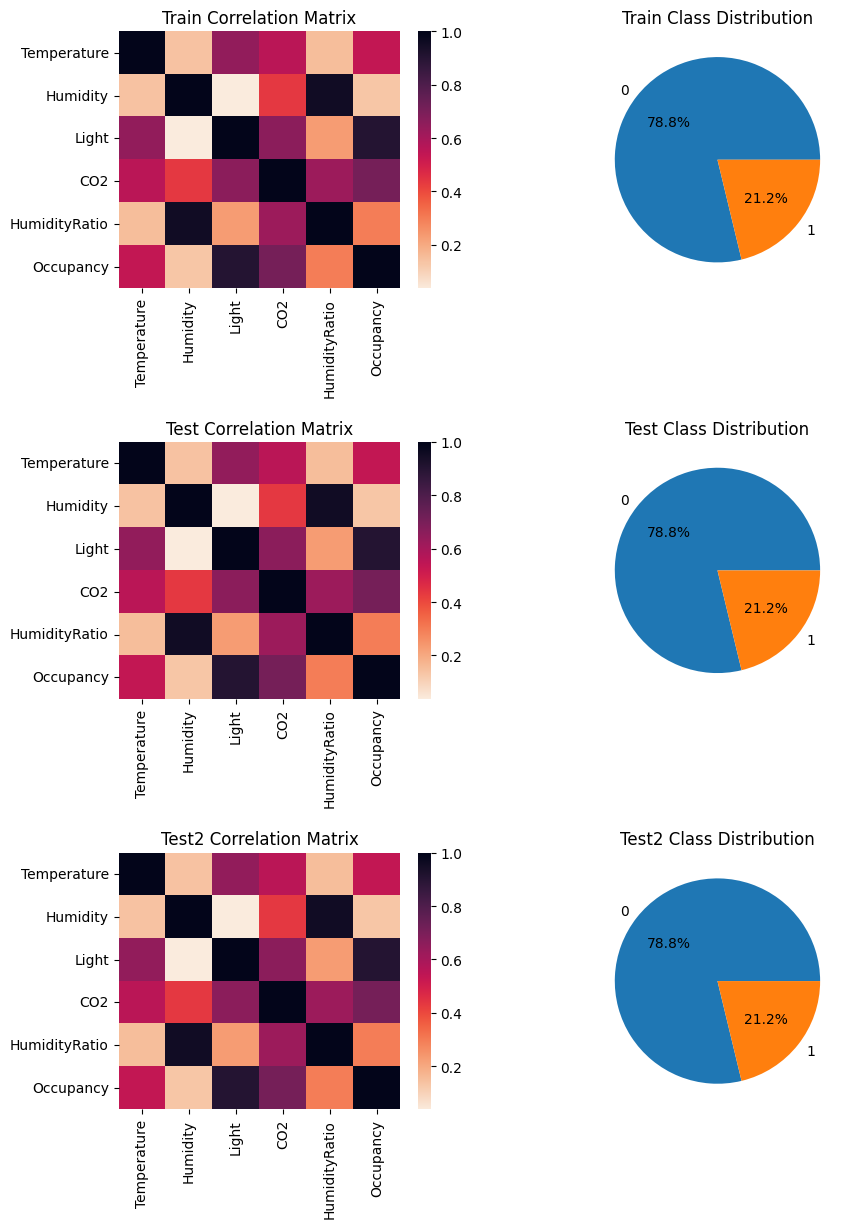

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heat_and_pie(name, data, axis, axis_index):
    axis[axis_index, 0].set_title(name + " Correlation Matrix")
    sns.heatmap(data.corr().abs(),annot=False, ax=ax[axis_index, 0], cmap='rocket_r')
    axis[axis_index, 1].set_title(name + " Class Distribution")
    axis[axis_index, 1].pie(x=data["Occupancy"].value_counts(), labels=data["Occupancy"].value_counts().index, autopct='%1.1f%%')

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,14))
fig.subplots_adjust(hspace=0.6)
plot_heat_and_pie("Train", train_data, ax, 0)
plot_heat_and_pie("Test", train_data, ax, 1)
plot_heat_and_pie("Test2", train_data, ax, 2)


The class imbalance of occupancy in the test set is likely due to this being real world timeset with respect to humans in the room and you can't just add more instances of humans in the room during a time period without redoing the whole dataset, the way you could with a real dataset. We see that at least correlationwise in the training and test sets, the predictors change. 
Due to the large class imbalance and potentially negative consequences of false negatives, we will use F1 score as our metric for evaluation.

Finally we plot the normalized values of our features as lines and show the occupancy in the background (green for occupied, red for unoccupied), this visualization helps us greatly understand the nature of the dataset

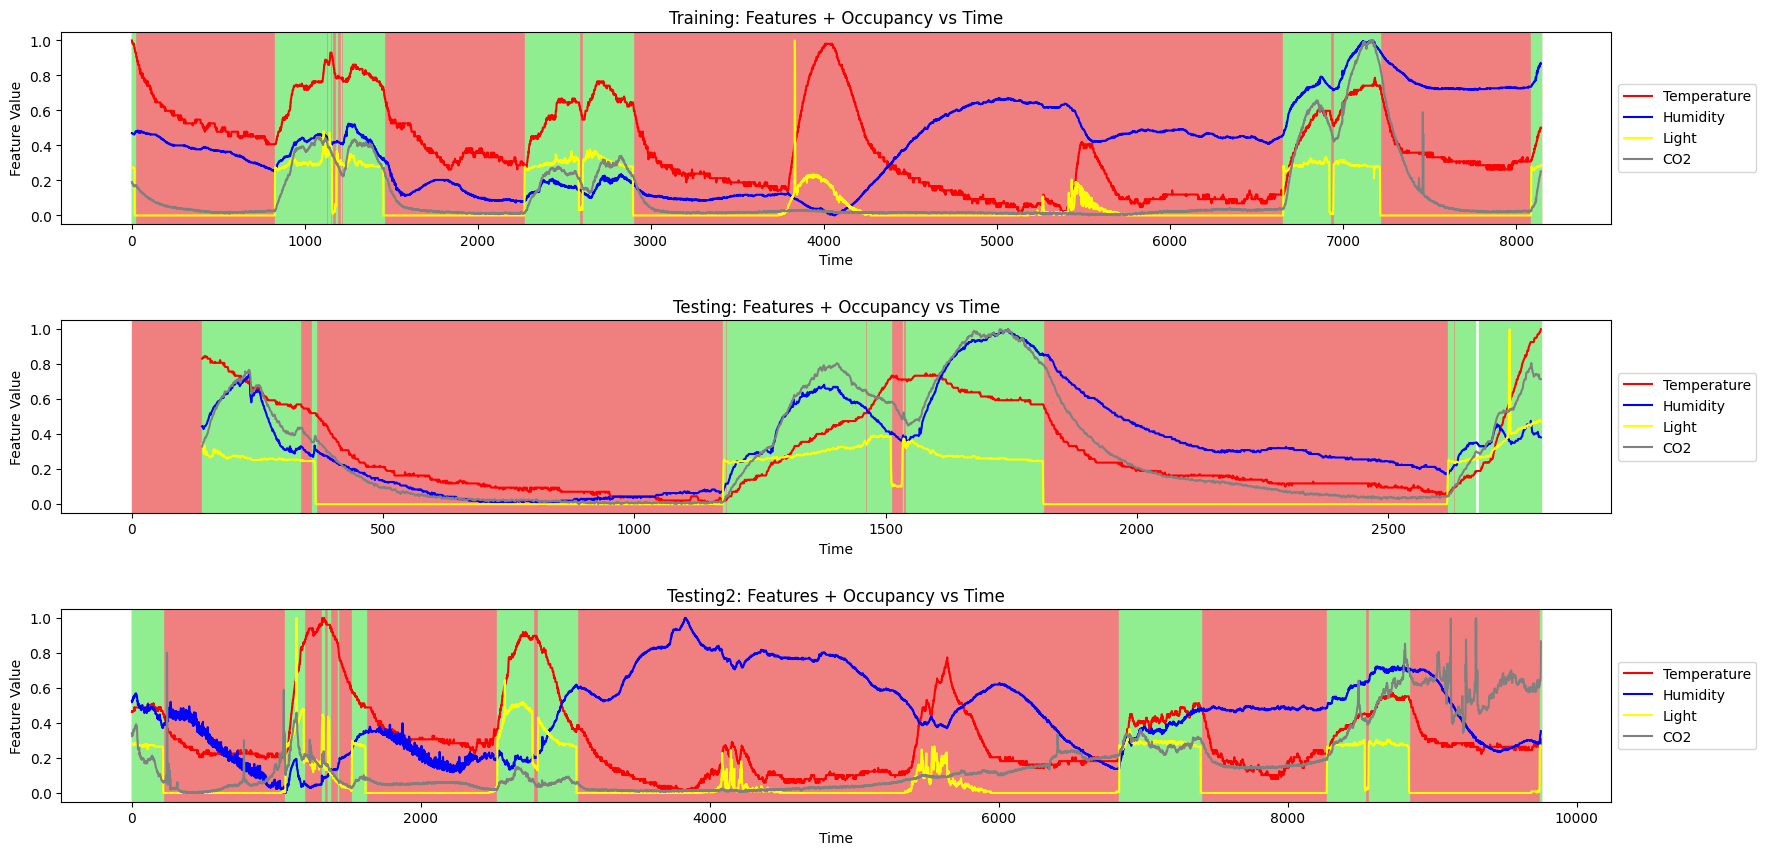

In [42]:
import numpy as np

def normalize_plot(data, label, color, axis):
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    axis.plot(data, label=label, color=color)

def plotData(name, data_frame, axis):
    #Algo for collecting when room is occupied spans for fast drawing
    occupancyFlag = 0
    occupancySpans = []
    for row in data_frame.iterrows(): 
        occupancyStatus = row[1]["Occupancy"]
        if occupancyFlag == 0 and occupancyStatus == 1:
            occupancyFlag = 1
            occupancySpans.append([row[0], None])
        elif occupancyFlag == 1 and occupancyStatus == 0:
            occupancyFlag = 0
            occupancySpans[-1][1] = row[0]
    if occupancyFlag == 1:
        occupancySpans[-1][1] = row[0]
    axis.axvspan(0, len(data_frame), color= "lightcoral") 
    for start, end in occupancySpans:
        axis.axvspan(start, end, color="lightgreen")

    normalize_plot(data_frame["Temperature"], "Temperature", "red", axis)
    normalize_plot(data_frame["Humidity"], "Humidity", "blue", axis)
    normalize_plot(data_frame["Light"], "Light", "yellow", axis)
    normalize_plot(data_frame["CO2"], "CO2", "grey", axis)
    axis.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axis.set_title(name + ": Features + Occupancy vs Time")
    axis.set_ylabel("Feature Value")
    axis.set_xlabel("Time")

fig, axs = plt.subplots(nrows=3, figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
plotData("Training", train_data, axs[0])
plotData("Testing", test_data, axs[1])
plotData("Testing2", test2_data, axs[2])


In [44]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader

#Creating a custom time series dataset in pytorch
class OccupancyDataset(Dataset):
    def __init__(self, data_frame, sequence_length):
        self.data = data_frame.to_numpy()
        self.features = self.data[:, :-1]
        self.labels = self.data[:, -1]
        self.sequence_length = sequence_length
    
    def __len__(self):
        return self.data.shape[0] - (self.sequence_length - 1)
    
    def __getitem__(self, index):
        return (self.features[:, index:index+self.sequence_length], self.labels[index+self.sequence_length-1])

#Testing that our dataset returns the elements we want in the correct shape